In [3]:
import awswrangler  as wr
import pandas as pd
# import pandas.io.json
import pymysql
import datetime
import json


# load sql
#
sql = '''
with ubl as
    (select
           from_iso8601_timestamp(json_extract_scalar(user_properties, '$.first_at'))  + interval '9' hour AS first_at
          , client_access_time as reg_ts
          ,  cast( json_extract_scalar ( event_properties , '$.stay_time_seconds') as integer) as stay_time
          , case
            when device like 'Web%' then case when device like '%Mobile%'  then 'mobile_web'
                                when device like '%Desktop%' then  'desktop'  end
            when device like 'App%' then 'App'

end as device_type
         , *
     from moyo_logs.user_behavior_logs
     where 1 = 1

       and date_ymd between '2023-03-10' and '2023-06-01'
-- limit 1000
-- 23년 3월동안 가입한 유저들이 30일 동안 재방문 가능성
)
, merge as (
select
user_id
, uuid
from ubl
where 1 = 1
    and cast(user_id as double) <> 0
    and user_id is not null
--     and device_type = 'App'
group by 1, 2
order by 1
)
select
 device_type
, user_id
, count( distinct uuid ) as uuid_cnt
, count( * ) as event_cnt
from ubl
where 1=1
    and user_id is not null
group by 1,2

'''
# sql_v1 = ''' 
# select *
# from moyo_scraping.mno_scraping_result
# where 1=1
#     and version = 1 
# '''
# sql_v2 = '''
# select *
# from moyo_scraping.mno_scraping_result
# where 1=1

#     and version = 2
# '''
df_v1= wr.athena.read_sql_query(sql=sql, database="moyo_order")

In [6]:
df_v1.head(1)


,device_type,user_id,uuid_cnt,event_cnt
0,mobile_web,106116,2,304


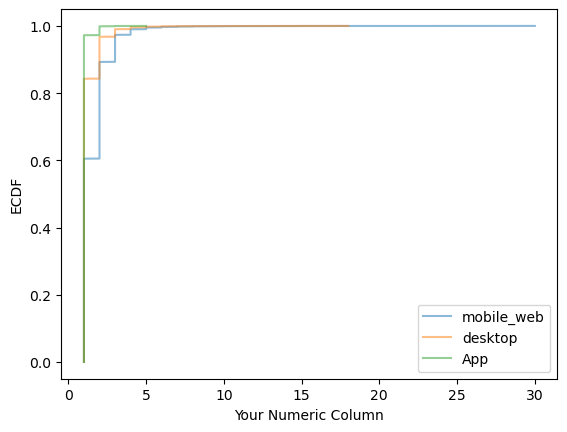

In [19]:
# ecdf plot 
# Path: Workbook/user_behavier_churn _and_duplicated_auth/user_duplicated_auth.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame, and 'dimension' is your categorical variable

for category in df_v1['device_type'].unique():
    # Select data for this category
    data = df_v1[df_v1['device_type'] == category]

    # Compute ECDF
    x = np.sort(data['uuid_cnt'])
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    plt.plot(x, y, label=category, alpha = 0.5)

plt.xlabel('Your Numeric Column')
plt.ylabel('ECDF')
plt.legend()
plt.show()

